In [1]:
!pip install openmesh

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 17.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for openmesh: filename=openmesh-1.2.1-cp38-cp38-linux_x86_64.whl size=856226 sha256=f6af6d7d8e99ea20270aa11575f5f25a472fd4d2b4b0c11f58b7bb292fc979a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-yt9_jp6i/wheels/5f/80/7e/95fd3ba2fe5d78b19d04e30f635417225a33dd79c1c01550c6
Successfully built openmesh


In [1]:
import sys
import csv
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import FuncAnimation
from functools import partial

from glob import glob
from tqdm import tqdm

import openmesh as om

sys.path.append(".")
sys.path.append('./third_party/ICT-FaceKit/Scripts')
try:
    import face_model_io
    has_ICT_orig = True

except ModuleNotFoundError:
    has_ICT_orig = False
has_ICT_orig

True

In [2]:
import face_model_io

In [3]:
def transform_string(s):
    s = s.replace('_L', 'Left')
    s = s.replace('_R', 'Right')
    return s[0].upper() + s[1:]

In [4]:
# Create a new FaceModel and load the model
face_model = face_model_io.load_face_model('./third_party/ICT-FaceKit/FaceXModel')

Loading face model...
Reading expression morph targets...
Reading expression morph target: browDown_L
Reading expression morph target: browDown_R
Reading expression morph target: browInnerUp_L
Reading expression morph target: browInnerUp_R
Reading expression morph target: browOuterUp_L
Reading expression morph target: browOuterUp_R
Reading expression morph target: cheekPuff_L
Reading expression morph target: cheekPuff_R
Reading expression morph target: cheekSquint_L
Reading expression morph target: cheekSquint_R
Reading expression morph target: eyeBlink_L
Reading expression morph target: eyeBlink_R
Reading expression morph target: eyeLookDown_L
Reading expression morph target: eyeLookDown_R
Reading expression morph target: eyeLookIn_L
Reading expression morph target: eyeLookIn_R
Reading expression morph target: eyeLookOut_L
Reading expression morph target: eyeLookOut_R
Reading expression morph target: eyeLookUp_L
Reading expression morph target: eyeLookUp_R
Reading expression morph tar

[OBJReader] : cannot not open file ./third_party/ICT-FaceKit/FaceXModel/identity100.obj


In [67]:
ict_keys = [transform_string(item) for item in face_model._expression_names]

# csv_file_path = r"/data/sihun/arkit_CSH/MySlate_7_iPhone.csv"
# csv_file_path = r"sample_data/MySlate_10_iPhone.csv"
#csv_file_path = r"MySlate_10_iPhone_mp.csv"
# csv_file_path = r"/source/sihun/MAASA/tmp/MEADcapture/m003-angry-level_03-026.csv"
csv_file_path = r"/source/sihun/MAASA/tmp/Selfcapture/MySlate_10_iPhone.csv"

"""Converts a CSV file to a JSON file."""
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    
    data = [row for row in csv_reader]
data_keys = list(data[0].keys())

In [68]:
key_list = []
for key in ict_keys: 
    if key in data_keys:
        key_list.append(key)
    else:
        for _k in data_keys:
            if _k in key:
                key_list.append(_k)
                break

In [69]:
frame_vertices = []
all_ex_coeffs = []
for idx, frame in enumerate(data):
# idx = 132
# frame =data[idx]
    ex_coeffs = []
    for key in key_list:
        ex_coeffs.append(frame[key])

    # blendshape 49
    ex_coeffs = np.array(ex_coeffs, dtype=np.float64) # (49,)
    all_ex_coeffs.append(ex_coeffs)
    face_model.set_expression(ex_coeffs)

    # Deform the mesh
    face_model.deform_mesh()

    # # Write the deformed mesh
    # face_model_io.write_deformed_mesh('/data/sihun/arkit_CSH/sample_identity_arkit_frame_{:06d}.obj'.format(idx), face_model)
    # # om.write_mesh(file_path, face_model._deformed_mesh, halfedge_tex_coord = True)
    
    frame_vertices.append(face_model._deformed_vertices.copy())

(375, 53)


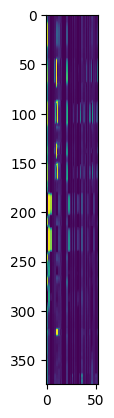

In [73]:
all_ex_coeffs = np.array(all_ex_coeffs)
all_ex_coeffs = all_ex_coeffs[88:]
print(all_ex_coeffs.shape)
plt.imshow(all_ex_coeffs)

In [72]:
# np.save('./tmp/MEADcapture/mead_rig_trimmed',all_ex_coeffs[56:202])
np.save('./tmp/Selfcapture/MySlate_10',all_ex_coeffs[88:])

In [65]:
len(frame_vertices)

480

In [10]:
## render utils
def frustum(left, right, bottom, top, znear, zfar):
    M = np.zeros((4, 4), dtype=np.float32)
    M[0, 0] = +2.0 * znear / (right - left)
    M[1, 1] = +2.0 * znear / (top - bottom)
    M[2, 2] = -(zfar + znear) / (zfar - znear)
    M[0, 2] = (right + left) / (right - left)
    M[2, 1] = (top + bottom) / (top - bottom)
    M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
    M[3, 2] = -1.0
    return M

def perspective(fovy, aspect, znear, zfar):
    h = np.tan(0.5*np.radians(fovy)) * znear
    w = h * aspect
    return frustum(-w, w, -h, h, znear, zfar)

def translate(x, y, z):
    return np.array([[1, 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]], dtype=float)

def yrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return  np.array([[ c, 0, s, 0],
                      [ 0, 1, 0, 0],
                      [-s, 0, c, 0],
                      [ 0, 0, 0, 1]], dtype=float)

def transform_vertices(frame_v, MVP, F):
    V = frame_v
    V = (V - (V.max(0) + V.min(0)) / 2) / max(V.max(0) - V.min(0))
    V = np.c_[V, np.ones(len(V))]
    V = V @ MVP.T
    V /= V[:, 3].reshape(-1, 1)
    VF = V[F]
    return VF


Rendering frames:  99%|████████████████████████████████████████▋| 145/146 [3:32:46<01:28, 88.04s/it]

Rendering frames:  99%|██████████████████████████████████████████▋| 145/146 [01:41<00:00,  1.45it/s]

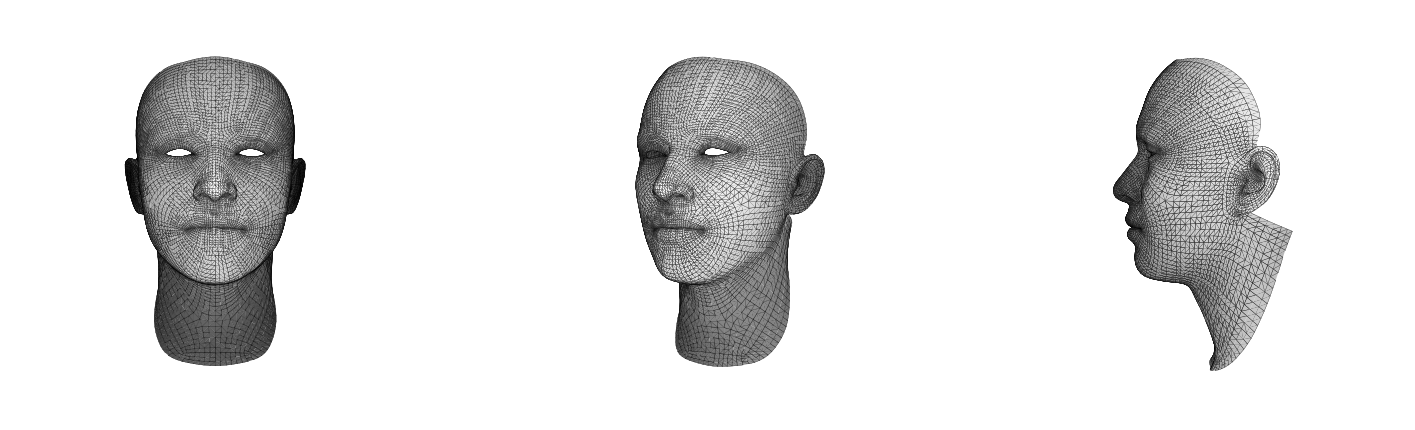

In [74]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from matplotlib.collections import PolyCollection
# from glob import glob
# import openmesh as om

# settings ------------------------------------------------------
FPS = 30
face_only = True
remove_axis =True
# ---------------------------------------------------------------

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(131, xlim=[-1, +1], ylim=[-1, +1], aspect=1, frameon=False)
ax2 = fig.add_subplot(132, xlim=[-1, +1], ylim=[-1, +1], aspect=1, frameon=False)
ax3 = fig.add_subplot(133, xlim=[-1, +1], ylim=[-1, +1], aspect=1, frameon=False)

if remove_axis:
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    
if face_only:
    ## face only
    v_idx, f_idx = 9409, 9230
else:
    ## face + head + neck
    v_idx, f_idx = 11248, 11144

# This is quad mesh!
quad_F  = face_model._generic_neutral_mesh.face_vertex_indices()[:f_idx]
tri_faces_1 = quad_F[:, [0, 1, 2]]
tri_faces_2 = quad_F[:, [0, 2, 3]]
F = np.vstack([tri_faces_1, tri_faces_2])
Vs = frame_vertices


# Pre-calculated transformation matrices for three views
proj = perspective(25, 1, 1, 100)
MVPs = [
    proj @ translate(0, 0, -2.5),
    proj @ translate(0, 0, -2.5) @ yrotate(-30),
    proj @ translate(0, 0, -2.5) @ yrotate(-90)
]
idx = 0

def render_mesh(ax, V, MVP, F):
    # quad to triangle
    VF = transform_vertices(V[:v_idx] , MVP, F)
    
    T = VF[:, :, :2]
    Z = -VF[:, :, 2].mean(axis=1)
    zmin, zmax = Z.min(), Z.max()
    Z = (Z - zmin) / (zmax - zmin)
    
    C = plt.get_cmap("gray")(Z)
    I = np.argsort(Z)
    T, C = T[I, :], C[I, :]
    
    collection = PolyCollection(T, closed=False, linewidth=0.23, facecolor=C, edgecolor="black")
    ax.add_collection(collection)

def update(V):
    # Cleanup previous collections
    for ax in [ax1, ax2, ax3]:
        for coll in ax.collections:
            coll.remove()
    
    # Render meshes for all views
    for ax, MVP in zip([ax1, ax2, ax3], MVPs):
        render_mesh(ax, V, MVP, F)

    return ax1.collections + ax2.collections + ax3.collections

ani = FuncAnimation(fig, update, frames=tqdm(Vs, desc="Rendering frames", ncols=100), blit=True) # Vs[56:202]


### can be saved in difference format
ani.save('tmp/rendered_video_quad.mp4', writer='ffmpeg', fps=FPS)


In [75]:
from IPython.display import Video
# Video("sample_data/arkit_CSH_.mp4")
#Video("sample_data/arkit_CSH.mp4")
Video("tmp/rendered_video_quad.mp4")

In [48]:
import subprocess
audio_path = '/source/sihun/MAASA/tmp/MEADcapture/output_026.wav'
result_path='tmp/rendered_video_quad2'
cmd = f"ffmpeg -y -i {audio_path} -i tmp/rendered_video_quad.mp4 -c:v copy -c:a aac {result_path}.mp4"
subprocess.call(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

# mux audio and video
print("[INFO] mux audio and video")
# cmd = f"ffmpeg -y -i {audio_path} -i tmp/rendered_video_quad.mp4 -c:v copy -c:a aac tmp/rendered_video_quad3.mp4"
# subprocess.call(cmd, shell=True)


[INFO] mux audio and video


In [57]:
# 1. WAV 파일의 길이 측정0
cmd = f"ffprobe -i {audio_path} -show_entries format=duration -v quiet -of csv='p=0'"
subprocess.call(cmd, shell=True, stderr=subprocess.STDOUT)

# # 2. MP4 파일의 길이 측정
# 
result_path_ = 'tmp/dubbing22_src.mp4'
cmd = f"ffprobe -i {result_path_} -show_entries format=duration -v quiet -of csv='p=0'"
subprocess.call(cmd, shell=True, stderr=subprocess.STDOUT)

# # 3. WAV 파일의 길이가 MP4 파일의 길이보다 길다면, WAV 파일의 끝 부분을 잘라냄
# 
trimmed_wav='tmp/trimmed.wav'
cmd = f"ffmpeg -i {audio_path} -ss 0 -to 2.6 -c copy {trimmed_wav}"
subprocess.call(cmd, shell=True, stderr=subprocess.STDOUT)


# # 4. 잘라낸 WAV 파일과 MP4 파일을 병합
# ffmpeg -i input.mp4 -i trimmed.wav -c:v copy -c:a aac -strict experimental output.mp4

IPython.display.Audio(trimmed_wav)

4.714667


0

In [42]:
import IPython
IPython.display.Audio(audio_path)

In [43]:

Video("tmp/rendered_video_quad3.mp4")

In [28]:
!ffmpeg -i /source/sihun/MAASA/tmp/MEADcapture/026.mp4 ./tmp/output_026.wav

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [13]:
!ffmpeg -i MySlate_10_iPhone.mov -vn -acodec pcm_s16le -ar 44100 -ac 2 MySlate_10_iPhone.wav

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e